# JAX-CFD demo

This initial demonstration shows how to use JAX-CFD to simulate decaying turbulence in 2D.

In [1]:
!pip install git+https://github.com/mininmy/jax-cfd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mininmy/jax-cfd to /tmp/pip-req-build-clm9dmqq
  Running command git clone --filter=blob:none --quiet https://github.com/mininmy/jax-cfd /tmp/pip-req-build-clm9dmqq
  Resolved https://github.com/mininmy/jax-cfd to commit 95402cc59d0d0974dd99b2f2b0b7197aa15f6b30
  Preparing metadata (setup.py) ... done


In [2]:
import jax
import jax.numpy as jnp
import jax_cfd.base as cfd
import numpy as np
import seaborn
import xarray

In [3]:
size = 128
density = 1.
viscosity = 1e-3
seed = 0
inner_steps = 25
outer_steps = 200

max_velocity = 2.0
cfl_safety_factor = 0.5

# Define the physical dimensions of the simulation.
grid = cfd.grids.Grid((size, size, size), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi), (0, 2 * jnp.pi)))

# Construct a random initial velocity. The `filtered_velocity_field` function
# ensures that the initial velocity is divergence free and it filters out
# high frequency fluctuations.
v0 = cfd.initial_conditions.filtered_velocity_field(
    jax.random.PRNGKey(seed), grid, max_velocity)

# Choose a time step.
dt = cfd.equations.stable_time_step(
    max_velocity, cfl_safety_factor, viscosity, grid)

# Define a step function and use it to compute a trajectory.
step_fn = cfd.funcutils.repeated(
    cfd.equations.semi_implicit_navier_stokes(
        density=density, viscosity=viscosity, dt=dt, grid=grid),
    steps=inner_steps)
rollout_fn = jax.jit(cfd.funcutils.trajectory(step_fn, outer_steps))
%time _, trajectory = jax.device_get(rollout_fn(v0))

CPU times: user 1h 10min 48s, sys: 12.1 s, total: 1h 11min
Wall time: 42min 43s


In [4]:
# JAX-CFD uses GridVariable objects for input/output. These objects contain:
#  - array data
#  - an "offset" that documents the position on the unit-cell where the data
#    values are located
#  - grid properties
#  - boundary conditions on the variable
with np.printoptions(edgeitems=1):
  for i, u in enumerate(trajectory):
    print(f'Component {i}: {u}')

Component 0: GridVariable(array=GridArray(data=array([[[[-3.2275197e-01, ..., -3.3849844e-01],
         ...,
         [-3.2618192e-01, ..., -3.3903679e-01]],

        ...,

        [[-3.7441230e-01, ..., -3.8795593e-01],
         ...,
         [-3.7628105e-01, ..., -3.8751987e-01]]],


       ...,


       [[[ 3.4495490e-04, ..., -1.6072593e-04],
         ...,
         [-2.8250509e-04, ..., -1.3430858e-03]],

        ...,

        [[-2.3696895e-03, ..., -2.5903087e-03],
         ...,
         [-2.8034269e-03, ..., -3.6143172e-03]]]], dtype=float32), offset=(1.0, 0.5, 0.5), grid=Grid(shape=(128, 128, 128), step=(0.04908738521234052, 0.04908738521234052, 0.04908738521234052), domain=((0.0, 6.283185307179586), (0.0, 6.283185307179586), (0.0, 6.283185307179586)))), bc=HomogeneousBoundaryConditions(types=(('periodic', 'periodic'), ('periodic', 'periodic'), ('periodic', 'periodic')), bc_values=((0.0, 0.0), (0.0, 0.0), (0.0, 0.0))))
Component 1: GridVariable(array=GridArray(data=array([[[[-0.

In [5]:
# load into xarray for visualization and analysis
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[0].data),
        'v': (('time', 'x', 'y'), trajectory[1].data),
    },
    coords={
        'x': grid.axes()[0],
        'y': grid.axes()[1],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

In [8]:
ds = xarray.Dataset(
    {
        'u': (('time', 'x', 'y'), trajectory[1].data),
        'v': (('time', 'x', 'y'), trajectory[2].data),
    },
    coords={
        'x': grid.axes()[1],
        'y': grid.axes()[2],
        'time': dt * inner_steps * np.arange(outer_steps)
    }
)

ValueError: ignored

In [7]:
ds

NameError: ignored

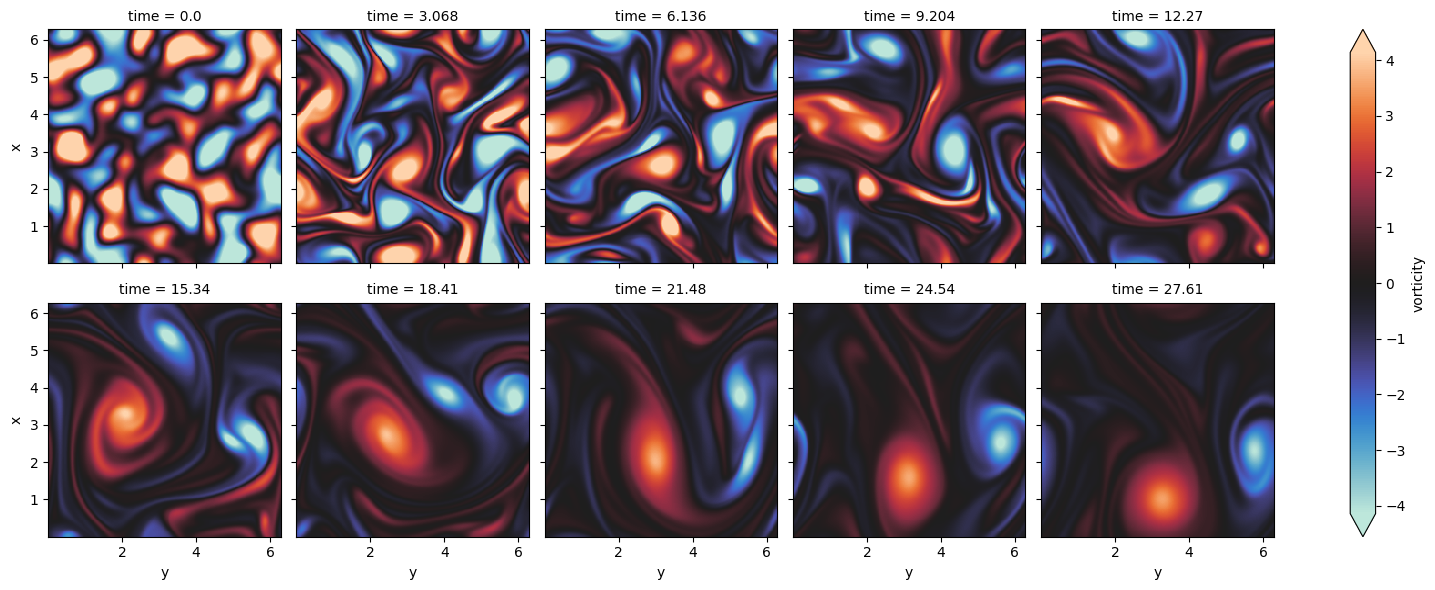

In [7]:
def vorticity(ds):
  return (ds.v.differentiate('x') - ds.u.differentiate('y')).rename('vorticity')

(ds.pipe(vorticity).thin(time=20)
 .plot.imshow(col='time', cmap=seaborn.cm.icefire, robust=True, col_wrap=5));